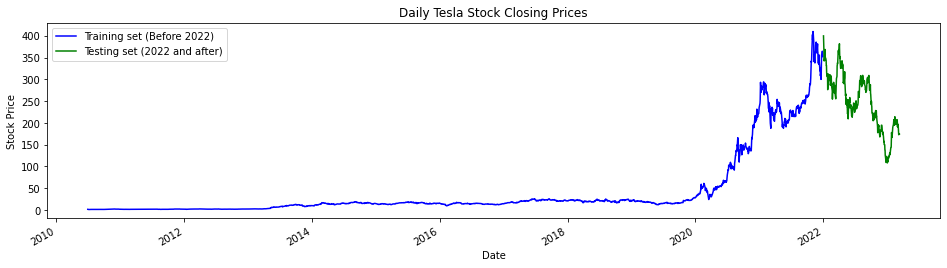

Epoch 1/5
89/89 [==============================] - 3s 11ms/step - loss: 0.0208
Epoch 2/5
89/89 [==============================] - 1s 11ms/step - loss: 6.7027e-04
Epoch 3/5
89/89 [==============================] - 1s 11ms/step - loss: 4.8148e-04
Epoch 4/5
89/89 [==============================] - 1s 11ms/step - loss: 3.9010e-04
Epoch 5/5
10/10 [==============================] - 1s 4ms/step
accuracy within 10%: 0.7391
accuracy within 15%: 0.8997
accuracy within 20%: 0.9732


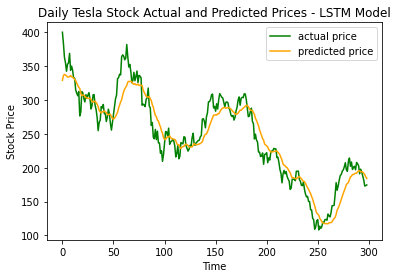

Epoch 1/5
89/89 [==============================] - 4s 12ms/step - loss: 0.0246
Epoch 2/5
89/89 [==============================] - 1s 12ms/step - loss: 0.0032
Epoch 3/5
89/89 [==============================] - 1s 13ms/step - loss: 1.5967e-04
Epoch 4/5
89/89 [==============================] - 1s 12ms/step - loss: 1.4051e-04
Epoch 5/5
10/10 [==============================] - 0s 3ms/step
accuracy within 10%: 0.9465
accuracy within 15%: 0.99
accuracy within 20%: 1


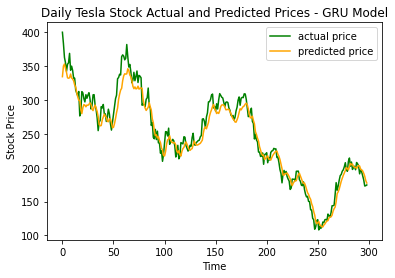

In [118]:
import numpy
import pandas
import matplotlib.pyplot as plt
from statistics import mean

from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.random import set_seed

tsla_data=pandas.read_csv('./TSLA.csv', index_col="Date", parse_dates=["Date"])

#plotting daily Tesla stock closing prices
time_start = 2010
time_end = 2021
tsla_data.loc[f"{time_start}":f"{time_end}", "Close"].plot(figsize=(16, 4), color="blue", legend=True)
tsla_data.loc[f"{time_end+1}":, "Close"].plot(figsize=(16, 4), color="green", legend=True)
plt.legend([f"Training set (Before {time_end+1})", f"Testing set ({time_end+1} and after)"])
plt.title("Daily Tesla Stock Closing Prices")
plt.ylabel("Stock Price")
plt.show()  

#rescaling data
tsla_data["Close_sc"]=(tsla_data["Close"]-min(tsla_data["Close"]))/(max(tsla_data["Close"].values)-min(tsla_data["Close"]))
train_set=tsla_data.loc[f"{time_start}":f"{time_end}", "Close_sc"].values
test_set=tsla_data.loc[f"{time_end+1}":, "Close_sc"].values

#splitting training data into samples
nsteps=60  #width of sliding window

def split_sequence(sequence, n_steps):
    x, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return numpy.array(x), numpy.array(y)

train_x, train_y=split_sequence(train_set, nsteps)

###############################################################
#FITTING LSTM MODEL
###############################################################
features=1 #predictors and response are the same variable
#reshaping train_x
train_x=train_x.reshape(train_x.shape[0], train_x.shape[1],features)

#specifying LSTM model architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=6, activation="tanh", input_shape=(nsteps, features)))
model_lstm.add(Dense(units=1))

#compiling the model
model_lstm.compile(loss="mse")
model_lstm.fit(train_x, train_y, epochs=5, batch_size=32)

#creating testing set by adding nsteps observations from training set to testing set
inputs=tsla_data.loc[:,"Close_sc"][len(tsla_data)-len(test_set)-nsteps:].values
inputs=inputs.reshape(-1, 1)

#splitting into samples
test_x, test_y=split_sequence(inputs, nsteps)

#reshaping
test_x=test_x.reshape(test_x.shape[0], test_x.shape[1], features)

#predicting for testing data
pred_y=model_lstm.predict(test_x)

#inverse transforming the values
pred_y=pred_y*(max(tsla_data["Close"].values)-min(tsla_data["Close"]))+min(tsla_data["Close"])
test_y=test_y*(max(tsla_data["Close"].values)-min(tsla_data["Close"]))+min(tsla_data["Close"])

#computing prediction accuracy
ind10=[]
ind15=[]
ind20=[]     

for sub1, sub2 in zip(pred_y, test_y):
    ind10.append(1) if abs(sub1-sub2)<0.10*sub2 else ind10.append(0)
    ind15.append(1) if abs(sub1-sub2)<0.15*sub2 else ind15.append(0)
    ind20.append(1) if abs(sub1-sub2)<0.20*sub2 else ind20.append(0)
   
print('accuracy within 10%:', round(mean(ind10),4))
print('accuracy within 15%:', round(mean(ind15),4))
print('accuracy within 20%:', round(mean(ind20),4))
    
#plotting actual and predicted values for testing data
plt.plot(test_y, color="green", label="actual price")
plt.plot(pred_y, color="orange", label="predicted price")
plt.title("Daily Tesla Stock Actual and Predicted Prices - LSTM Model")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()
    
###############################################################
#FITTING GRU MODEL
###############################################################
#specifying GRU model architecture
model_gru = Sequential()
model_gru.add(GRU(units=6, activation="tanh", input_shape=(nsteps, features)))
model_gru.add(Dense(units=1))

# Compiling the model
model_gru.compile(loss="mse")
model_gru.fit(train_x, train_y, epochs=5, batch_size=32)

#predicting for testing data
pred_y=model_gru.predict(test_x)

#inverse transforming the values
pred_y=pred_y*(max(tsla_data["Close"].values)-min(tsla_data["Close"]))+min(tsla_data["Close"])

#computing prediction accuracy
ind10=[]
ind15=[]
ind20=[]     

for sub1, sub2 in zip(pred_y, test_y):
    ind10.append(1) if abs(sub1-sub2)<0.10*sub2 else ind10.append(0)
    ind15.append(1) if abs(sub1-sub2)<0.15*sub2 else ind15.append(0)
    ind20.append(1) if abs(sub1-sub2)<0.20*sub2 else ind20.append(0)
   
print('accuracy within 10%:', round(mean(ind10),4))
print('accuracy within 15%:', round(mean(ind15),4))
print('accuracy within 20%:', round(mean(ind20),4))
    
#plotting actual and predicted values for testing data
plt.plot(test_y, color="green", label="actual price")
plt.plot(pred_y, color="orange", label="predicted price")
plt.title("Daily Tesla Stock Actual and Predicted Prices - GRU Model")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()